In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import cvxpy as cp
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
grid_df = pd.read_csv('./data/grid_data.csv')
grid_df.head()

,day,solar (MW),wind (MW),load (MW),solar_forcast (MW),wind_forecast (MW),load_forecast (MW),price (EUR/MWh),emission factor (kg CO2/MWh)
0,0,0.0,5393.0,11257.0,0.0,6053.0,10783.0,0.10,73.013522
1,0,0.0,5415.0,11279.0,0.0,6037.0,10713.0,0.10,73.013522
2,0,0.0,5405.0,11291.0,0.0,6023.0,10626.0,0.10,73.013522
3,0,0.0,5411.0,11266.0,0.0,6008.0,10527.0,0.10,73.013522
4,0,0.0,5441.0,11312.0,0.0,5993.0,10457.0,0.01,73.224798


In [3]:
grid_df.mean()

day                               182.500000
solar (MW)                         55.483918
wind (MW)                        2597.033901
load (MW)                       13083.216099
solar_forcast (MW)                810.036804
wind_forecast (MW)               2067.183223
load_forecast (MW)              11378.150632
price (EUR/MWh)                    77.287675
emission factor (kg CO2/MWh)      202.486892
dtype: float64

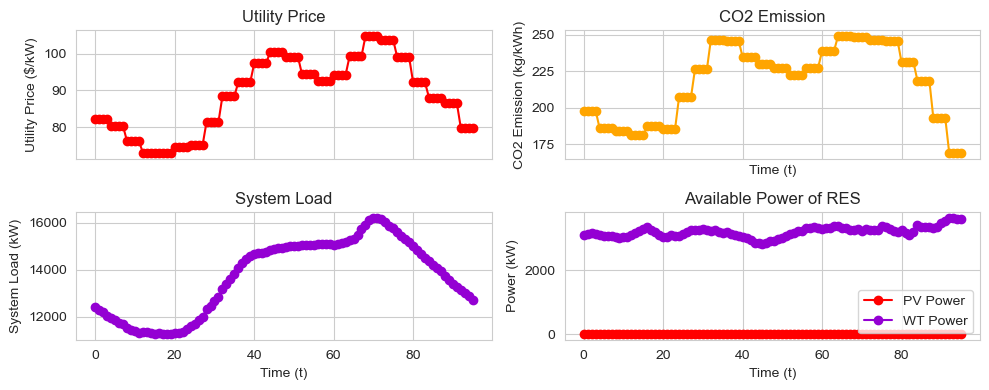

In [4]:
DAY_NUM = 5

grid_df[grid_df['day']==DAY_NUM]["emission factor (kg CO2/MWh)"].to_numpy()

pv_data = grid_df[grid_df['day']==DAY_NUM]["solar (MW)"].to_numpy()
wt_data = grid_df[grid_df['day']==DAY_NUM]["wind (MW)"].to_numpy()
price_data = grid_df[grid_df['day']==DAY_NUM]["price (EUR/MWh)"].to_numpy()
load_data = grid_df[grid_df['day']==DAY_NUM]["load (MW)"].to_numpy()
co2_data = grid_df[grid_df['day']==DAY_NUM]["emission factor (kg CO2/MWh)"].to_numpy()

# Create the index array (1 to 24) for the horizontal axis
t = np.arange(0, len(pv_data))

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 4), sharex=True)
axs = axs.flatten()

# Plot Price_utility
axs[0].plot(t, price_data, marker='o', linestyle='-', color='r')
axs[0].set_ylabel('Utility Price ($/kW)')
axs[0].set_title('Utility Price')
axs[0].grid(True)

# Plot CO2_emission
axs[1].plot(t, co2_data, marker='o', linestyle='-', color='orange')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('CO2 Emission (kg/kWh)')
axs[1].set_title('CO2 Emission')
axs[1].grid(True)

# Plot Power_load
axs[2].plot(t, load_data, marker='o', linestyle='-', color='darkviolet')
axs[2].set_xlabel('Time (t)')
axs[2].set_ylabel('System Load (kW)')
axs[2].set_title('System Load')
axs[2].grid(True)

# Plot PV/Wind
axs[3].plot(t, pv_data, marker='o', linestyle='-', color='r', label='PV Power')
axs[3].plot(t, wt_data, marker='o', linestyle='-', color='darkviolet', label='WT Power')
axs[3].set_xlabel('Time (t)')
axs[3].set_ylabel('Power (kW)')
axs[3].set_title('Available Power of RES')
axs[3].grid(True)
axs[3].legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


## 2d plot

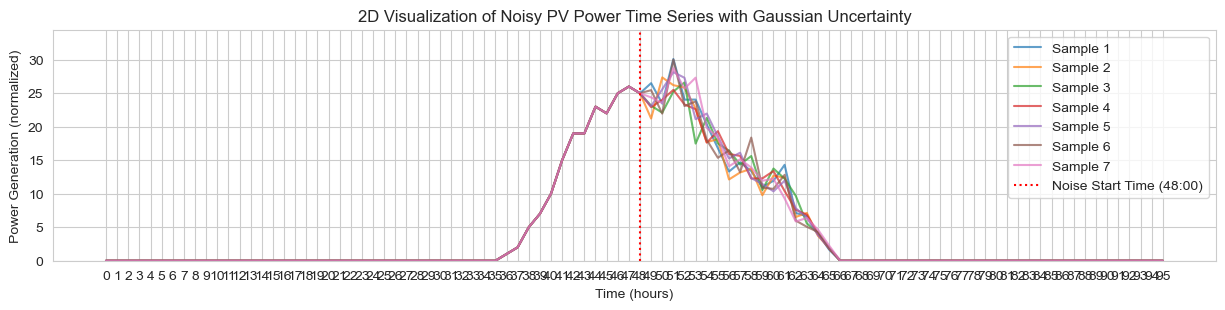

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate a Gaussian time series
def generate_pv_power(mean, std):
    time_steps = np.linspace(0, 96, 96)  # 15-minute resolution
    power = np.exp(-0.5 * ((time_steps - mean) / std)**2)  # Gaussian curve
    return time_steps, power

# Function to add Gaussian noise with varying intensity and proportional to power
def add_uncertainty(time_series, start_time, base_noise_std):
    time_steps = np.linspace(0, len(time_series), len(time_series))
    noisy_series = time_series.copy()
    start_index = np.searchsorted(time_steps, start_time)+1
    total_horizon = len(time_series) - start_index

    # Define the Gaussian uncertainty function
    for i in range(start_index, len(time_series)):
        time_distance = (i - start_index) / total_horizon  # Normalize distance to [0, 1]
        # Gaussian function for uncertainty, centered at the midpoint of the horizon
        uncertainty_scale = np.exp(-0.5 * ((time_distance - 1) ** 2) / (0.7 ** 2))  # Narrow Gaussian
        noise_scale = base_noise_std * uncertainty_scale  # Scale noise by the Gaussian function
        noise = np.random.normal(0, noise_scale) * noisy_series[i]
        noisy_series[i] += noise

    noisy_series[start_index:] = np.clip(noisy_series[start_index:], 0, None)  # Ensure no negative power
    return noisy_series

# Function to plot multiple samples in 2D
def plot_2d_samples(time_steps, power_series, start_time, base_noise_std, num_samples=5):
    plt.figure(figsize=(15, 3))

    for i in range(num_samples):
        noisy_series = add_uncertainty(power_series, start_time, base_noise_std)
        plt.plot(time_steps, noisy_series, label=f'Sample {i+1}', alpha=0.7)

    # plt.plot(time_steps, power_series, label='Original PV Power', color='black', linewidth=2)
    plt.axvline(start_time, color='red', linestyle=':', label=f'Noise Start Time ({start_time}:00)')

    # Set x-axis ticks
    hours_ticks = np.arange(0, len(power_series), 1)
    plt.xticks(hours_ticks, minor=False)


    plt.title("2D Visualization of Noisy PV Power Time Series with Gaussian Uncertainty")
    plt.xlabel("Time (hours)")
    plt.ylabel("Power Generation (normalized)")
    plt.legend()
    # plt.grid()
    plt.ylim([0, np.max(noisy_series)*1.2])
    plt.show()

    return noisy_series

# Main code
noisy_series = plot_2d_samples(t, pv_data, start_time=48, base_noise_std=0.2, num_samples=7)


# CVPXY 

In [6]:
#  Define the dictionary
DG_coeffs = {
    "MT": {
        "Pmin": 6,  # kW
        "Pmax": 30, # kW
        "b" : 4.37, # €/kWh
        "c": 85.06, # €/h
        "ef": 724.6/1000,# kg/kWh
        "Type": "Microturbine"
    },
    "FC": {
        "Pmin": 3,   # kW
        "Pmax": 30,  # kW
        "b": 2.84,   # €/kWh
        "c": 255.18, # €/h
        "ef": 489.4/1000, # kg/kWh
        "Type": "FC"
    },
    "WT": {
        "Pmin": 0,  # kW
        "Pmax": 15, # kW
        "b": 10.63, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Wind Turbine"
    },
    "PV1": {
        "Pmin": 0,  # kW
        "Pmax": 3,  # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 1"
    },
    "PV2": {
        "Pmin": 0 , # kW
        "Pmax": 10, # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 2"
    }
}

# Print the dictionary
pprint(DG_coeffs)


{'FC': {'Pmax': 30,
        'Pmin': 3,
        'Type': 'FC',
        'b': 2.84,
        'c': 255.18,
        'ef': 0.4894},
 'MT': {'Pmax': 30,
        'Pmin': 6,
        'Type': 'Microturbine',
        'b': 4.37,
        'c': 85.06,
        'ef': 0.7246},
 'PV1': {'Pmax': 3,
         'Pmin': 0,
         'Type': 'Photovoltaic 1',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'PV2': {'Pmax': 10,
         'Pmin': 0,
         'Type': 'Photovoltaic 2',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'WT': {'Pmax': 15,
        'Pmin': 0,
        'Type': 'Wind Turbine',
        'b': 10.63,
        'c': 0,
        'ef': 0}}


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

class GridTimeSeriesDataset:
    def __init__(self, dataframe, scale=False):

        self.dataframe = dataframe
        self.days = np.sort(self.dataframe['day'].unique())  # Unique sorted days
        self.train, self.test = train_test_split(self.days, test_size=0.1, random_state=42)

        self.scale = scale
        if self.scale: self.load_samples()

        # Compute min and max values for normalization
        self.min = dataframe.min()
        self.max = dataframe.max()

    def __len__(self):
        return len(self.days)

    def __getitem__(self, index):
        if index >= len(self.days):
            raise IndexError("Index out of range")

        day = self.days[index]
        day_data = self.dataframe[self.dataframe['day'] == day].copy()
        
        if self.scale:
            day_data['solar (MW)'] = self.min_max_scale(day_data['solar (MW)'], ts_type='solar')
            day_data['wind (MW)'] = self.min_max_scale(day_data['wind (MW)'], ts_type='wind')
            day_data['load (MW)'] = self.min_max_scale(day_data['load (MW)'], ts_type='load')
            day_data['price (EUR/MWh)'] = self.min_max_scale(day_data['price (EUR/MWh)'], ts_type='price')
            day_data['emission factor (kg CO2/MWh)'] = self.min_max_scale(day_data['emission factor (kg CO2/MWh)'], ts_type='co2')
            # day_data['solar (MW)'] = self.scale_feature(day_data['solar (MW)'], ts_type='solar')
            # day_data['solar (MW)'] = self.remove_bias(day_data['solar (MW)'])
            # day_data['wind (MW)'] =  self.scale_feature(day_data['wind (MW)'], ts_type='wind')
            # day_data['load (MW)'] =  self.scale_feature(day_data['load (MW)'], ts_type='load')


        return {
            'time': np.arange(len(day_data)),  # Time indices
            'solar': day_data['solar (MW)'].to_numpy(dtype=np.float32),
            'wind': day_data['wind (MW)'].to_numpy(dtype=np.float32),
            'load': day_data['load (MW)'].to_numpy(dtype=np.float32),
            'solar_forecast': day_data['solar_forcast (MW)'].to_numpy(dtype=np.float32),
            'wind_forecast': day_data['wind_forecast (MW)'].to_numpy(dtype=np.float32),
            'load_forecast': day_data['load_forecast (MW)'].to_numpy(dtype=np.float32),
            'price': day_data['price (EUR/MWh)'].to_numpy(dtype=np.float32),
            'emission_factor': day_data['emission factor (kg CO2/MWh)'].to_numpy(dtype=np.float32),
        }
    
    def load_samples(self):
        # Load sample time series (to scale to the sample data)
        sample_solar = np.repeat(np.load('./data/sample/pv.npy'), 4)
        sample_wind = np.repeat(np.load('./data/sample/wt.npy'), 4)
        sample_load = np.repeat(np.load('./data/sample/load.npy'), 4)
        sample_price = np.repeat(np.load('./data/sample/price.npy'), 4)
        sample_co2 = np.repeat(np.load('./data/sample/co2.npy'), 4)/1000

        # Compute the mean and std of the sample time series
        self.mean_solar = np.mean(sample_solar)
        self.std_solar = np.std(sample_solar)
        self.min_solar = np.min(sample_solar)
        self.max_solar = np.max(sample_solar)

        self.mean_wind = np.mean(sample_wind)
        self.std_wind = np.std(sample_wind)
        self.min_wind = np.min(sample_wind)
        self.max_wind = np.max(sample_wind)

        self.mean_load = np.mean(sample_load)
        self.std_load = np.std(sample_load)
        self.min_load = np.min(sample_load)
        self.max_load = np.max(sample_load)

        self.mean_price = np.mean(sample_price)
        self.std_price = np.std(sample_price)
        self.min_price = np.min(sample_price)
        self.max_price = np.max(sample_price)

        self.mean_co2 = np.mean(sample_co2)
        self.std_co2 = np.std(sample_co2)
        self.min_co2 = np.min(sample_co2)
        self.max_co2 = np.max(sample_co2)

    # Apply Z-score standardization and rescale to sample's mean and std
    def scale_feature(self, data, ts_type):
        if ts_type == 'solar': mean_sample, std_sample = self.mean_solar, self.std_solar
        elif ts_type == 'wind': mean_sample, std_sample = self.mean_wind, self.std_wind
        elif ts_type == 'load': mean_sample, std_sample = self.mean_load, self.std_load

        feature_mean = np.mean(data)
        feature_std = np.std(data)
        return (data - feature_mean) / feature_std * std_sample + mean_sample

    def remove_bias(self, data):
        return data - np.min(data)
    
    def min_max_scale(self, data, ts_type):
        if ts_type == 'solar': min_sample, max_sample = self.min_solar, self.max_solar
        elif ts_type == 'wind': min_sample, max_sample = self.min_wind, self.max_wind
        elif ts_type == 'load': min_sample, max_sample = self.min_load, self.max_load
        elif ts_type == 'price': min_sample, max_sample = self.min_price, self.max_price
        elif ts_type == 'co2': min_sample, max_sample = self.min_co2, self.max_co2
        min_data = np.min(data)
        max_data = np.max(data)
        return (data - min_data) / (max_data - min_data) * (max_sample - min_sample) + min_sample


# Example Usage:
dataset = GridTimeSeriesDataset(grid_df, scale=True)
sample = dataset[42]
# print(sample)

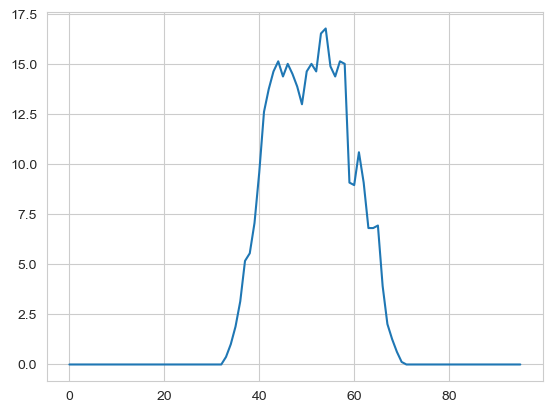

In [12]:
plt.plot(sample['time'], sample['solar'], label='Solar Power')

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Feb 07 10:40:16 PM: Your problem has 480 variables, 1152 constraints, and 0 parameters.
(CVXPY) Feb 07 10:40:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 07 10:40:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 07 10:40:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 07 10:40:16 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 07 10:40:16 PM: Compiling problem (target solver=SCIP).


(CVXPY) Feb 07 10:40:16 PM: Applying reduction SCIP
(CVXPY) Feb 07 10:40:16 PM: Finished problem compilation (took 1.520e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 07 10:40:16 PM: Invoking solver SCIP  to obtain a solution.
presolving:
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (0 rounds: 0 fast, 0 medium, 0 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 480 variables (0 bin, 0 int, 0 impl, 480 cont) and 1248 constraints
   1248 constraints of type <linear>
Presolving Time: 0.00

 time | node  | le

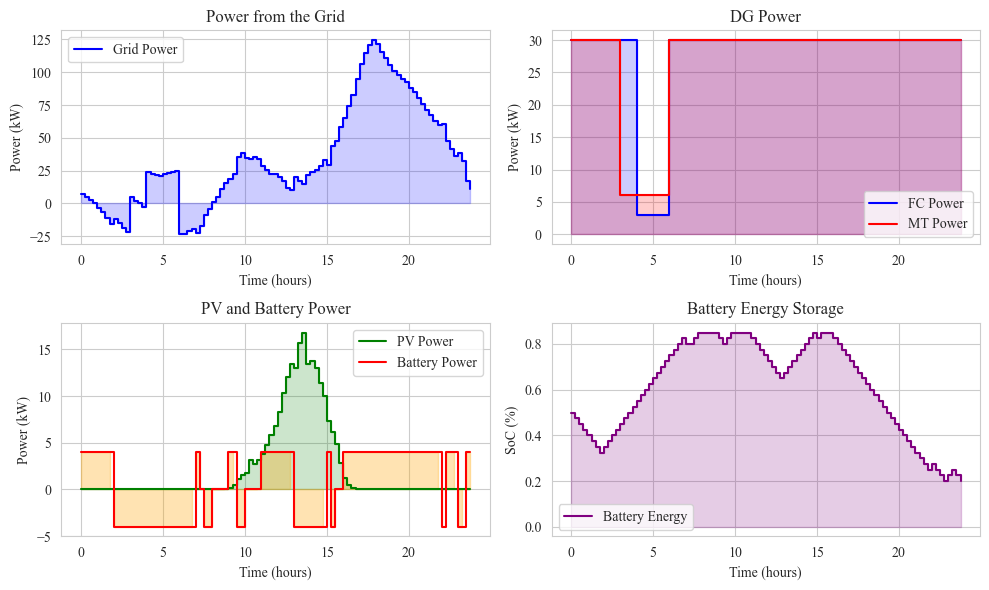

In [25]:

def solve_opt(pv_data_i, wt_data_i, load_data_i, price_data_i, co2_data_i, plot_results=True):
    # Parameters
    num_time_steps = len(pv_data_i)
    time_resolution = 0.25

    # Storage constraints
    storage_capacity = 40  # Example capacity
    capacity_high_limit = 0.85
    capacity_low_limit = 0.2

    PGmax = 200
    PBmax = 4

    # Decision Variables
    p_grid = cp.Variable(num_time_steps)
    p_FC = cp.Variable(num_time_steps)
    p_MT = cp.Variable(num_time_steps)
    p_storage = cp.Variable(num_time_steps)
    storage_energy = cp.Variable(num_time_steps, nonneg=True)

    # Constraints
    constraints = []

    # Power balance constraints
    constraints.append(2*pv_data_i + wt_data_i + p_grid + p_FC + p_MT + p_storage == load_data_i)

    # Grid constraints
    constraints.append(p_grid <= PGmax)
    constraints.append(p_grid >= -PGmax)

    # DG constraints
    constraints.append(p_FC <= DG_coeffs['FC']['Pmax'])
    constraints.append(p_FC >= DG_coeffs['FC']['Pmin'])
    constraints.append(p_MT <= DG_coeffs['MT']['Pmax'])
    constraints.append(p_MT >= DG_coeffs['MT']['Pmin'])

    # Storage constraints
    constraints.append(storage_energy <= storage_capacity * capacity_high_limit)
    constraints.append(storage_energy >= storage_capacity * capacity_low_limit)
    constraints.append(p_storage <= PBmax)
    constraints.append(p_storage >= -PBmax)
    constraints.append(storage_energy[0] == storage_capacity / 2)  # Initial storage level
    # constraints.append(storage_energy[-1] == storage_capacity / 2)

    constraints.append(storage_energy[1:] == storage_energy[:-1] - p_storage[1:] * time_resolution)

    # # Smoothing constraint to avoid abrupt changes
    # smoothing_penalty = cp.tv(p_grid_positive) + cp.tv(p_grid_negative) + cp.tv(p_storage) + cp.tv(p_chargers) 

    # Objective: Minimize total grid power usage, slack, and smoothing
    objective = cp.Minimize(
        cp.sum(cp.multiply(price_data_i, p_grid) + 0.01*cp.multiply(co2_data_i, p_grid)) + 
        cp.sum(DG_coeffs['FC']['c'] + cp.multiply(DG_coeffs['FC']['b'], p_FC) + 0.01*cp.multiply(DG_coeffs['FC']['ef'], p_FC)) + 
        cp.sum(DG_coeffs['MT']['c'] + cp.multiply(DG_coeffs['MT']['b'], p_MT) + 0.01*cp.multiply(DG_coeffs['MT']['ef'], p_MT))
    )

    # Problem definition and solving
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCIP, verbose=plot_results)
    
    if plot_results:
        # Output the results
        print("Problem status:", problem.status)
        if problem.status not in ["infeasible", "unbounded"]:
            print("Optimal objective value:", objective.value)
        else:
            print("The problem is infeasible or unbounded.")

        plt.figure(figsize=(10, 6))
        time_steps = np.arange(len(p_grid.value))*time_resolution

        # Plot grid power
        plt.subplot(2, 2, 1)
        plt.plot(time_steps, p_grid.value, label='Grid Power', color='blue', drawstyle='steps-post')
        plt.fill_between(time_steps, 0, p_grid.value, color='blue', alpha=0.2, step="post")
        plt.xlabel('Time (hours)')
        plt.ylabel('Power (kW)')
        plt.title('Power from the Grid')
        plt.legend()

        # Plot DG power
        plt.subplot(2, 2, 2)
        plt.plot(time_steps, p_FC.value, label='FC Power', color='blue', drawstyle='steps-post')
        plt.fill_between(time_steps, 0, p_FC.value, color='blue', alpha=0.2, step="post")

        plt.plot(time_steps, p_MT.value, label='MT Power', color='red', drawstyle='steps-post')
        plt.fill_between(time_steps, 0, p_MT.value, color='red', alpha=0.2, step="post")
        plt.xlabel('Time (hours)')
        plt.ylabel('Power (kW)')
        plt.title('DG Power')
        plt.legend()

        # Plot PV power and battery power
        plt.subplot(2, 2, 3)
        plt.plot(time_steps, pv_data_i, label='PV Power', color='green', drawstyle='steps-post')
        plt.fill_between(time_steps, 0, pv_data_i, color='green', alpha=0.2, step="post")
        plt.plot(time_steps, p_storage.value, label='Battery Power', color='red', drawstyle='steps-post')
        plt.fill_between(time_steps, 0, p_storage.value, where=np.array(p_storage.value) >= 0, color='orange', alpha=0.3, step="post")
        plt.fill_between(time_steps, 0, p_storage.value, where=np.array(p_storage.value) <= 0, color='orange', alpha=0.3, step="post")
        plt.xlabel('Time (hours)')
        plt.ylabel('Power (kW)')
        plt.title('PV and Battery Power')
        plt.legend()

        # Plot battery energy
        plt.subplot(2, 2, 4)
        plt.plot(time_steps, np.array(storage_energy.value) / storage_capacity, label='Battery Energy', color='purple', drawstyle='steps-post')
        plt.fill_between(time_steps, 0, np.array(storage_energy.value) / storage_capacity, color='purple', alpha=0.2, step="post")
        plt.xlabel('Time (hours)')
        plt.ylabel('SoC (%)')
        plt.title('Battery Energy Storage')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return p_grid.value, p_FC.value, p_MT.value, p_storage.value, storage_energy.value, objective.value


DAY_NUM = 6
    
p_grid, p_FC, p_MT, p_storage, storage_energy, optimial_cost = solve_opt(dataset[DAY_NUM]["solar"],
                                                                         dataset[DAY_NUM]["wind"],
                                                                         dataset[DAY_NUM]["load"],
                                                                         dataset[DAY_NUM]["price"],
                                                                         dataset[DAY_NUM]["emission_factor"])

# Optimal on Test

In [23]:
costs = []
rewards = []

for d in dataset.test:
    p_grid, p_FC, p_MT, p_storage, storage_energy, optimial_cost = solve_opt(dataset[d]["solar"],
                                                                             dataset[d]["wind"],
                                                                             dataset[d]["load"],
                                                                             dataset[d]["price"],
                                                                             dataset[d]["emission_factor"], 
                                                                             plot_results=False)
                
    costs.append(optimial_cost)
    reward = -optimial_cost/1e3 + 2*96
    rewards.append(reward)

np.mean(costs), np.mean(rewards)
    

(146671.39984405672, 45.32860015594328)

## Plot Results

#### energy balance

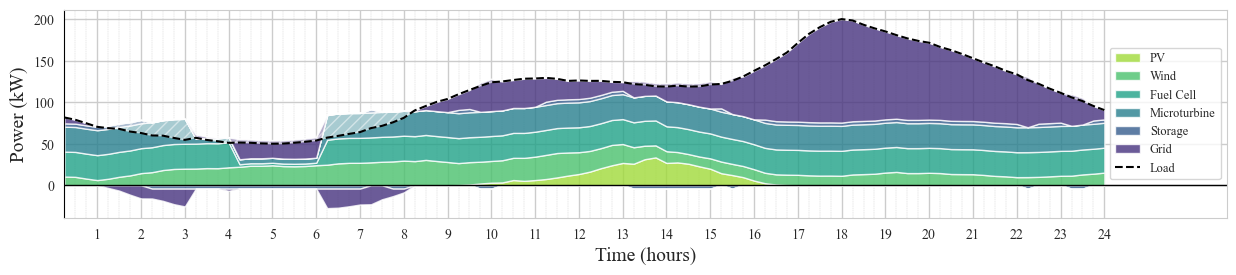

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
colors = sns.color_palette("viridis_r") # mako_r

plt.rcParams['font.family'] = 'Times New Roman'

# Extract data for the selected day
pv_data = dataset[DAY_NUM]["solar"]
wt_data = dataset[DAY_NUM]["wind"]
load_data = dataset[DAY_NUM]["load"]
price_data = dataset[DAY_NUM]["price"]
co2_data = dataset[DAY_NUM]["emission_factor"]

# Time steps (assuming hourly data)
time_steps = np.arange(len(pv_data))/4+0.25

# Separate positive and negative power components
p_storage_pos = np.maximum(p_storage, 0)
p_storage_neg = np.minimum(p_storage, 0)
p_grid_pos = np.maximum(p_grid, 0)
p_grid_neg = np.minimum(p_grid, 0)

# Stack power sources
pos_stack = np.vstack([2*pv_data, wt_data, p_FC, p_MT, p_storage_pos, p_grid_pos])
neg_stack = np.vstack([p_storage_neg, p_grid_neg])

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(15, 2.7))

# Plot stacked positive power sources
# colors = ['gold', 'skyblue', 'green', 'orange', 'purple', 'gray']
ax1.stackplot(time_steps, pos_stack, labels=['PV', 'Wind', 'Fuel Cell', 'Microturbine', 'Storage', 'Grid'], colors=colors, alpha=0.8)

# Plot stacked negative power sources below zero
ax1.stackplot(time_steps, neg_stack, colors=colors[-2:], alpha=0.8)

plt.fill_between(time_steps, load_data, load_data-p_grid_neg-p_storage_neg, color='white', alpha=0.5, hatch='///')

# Load profile as a line plot
line1, = ax1.plot(time_steps, load_data, color='black', linewidth=1.5, linestyle='--', label='Load')

# Labels and grid
ax1.set_xlabel('Time (hours)', size=14)
ax1.set_ylabel('Power (kW)', size=14)
ax1.axhline(0, color='black', linewidth=1)
# ax1.axvline(0, color='black', linewidth=0.5)

ax1.grid(True, which='minor', linestyle='--', linewidth=0.3)
ax1.grid(True, which='major', linestyle='-', linewidth=1)

# Set x-axis ticks
minor_hours = np.arange(0, 24.25, 0.25)
major_hours = np.arange(0, 24.25, 1)
plt.xticks(minor_hours, minor=True)
plt.xticks(major_hours, minor=False)
ax1.set_xlim([0.25,26.8]) 
ax1.legend(loc='right', fontsize=9)
ax1.spines['left'].set_color('black')
# for spine in ['bottom', 'left', 'right']:
#         ax1.spines[spine].set_color('black')
# Save the figure
plt.savefig('balance.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


#### buy and sell with price

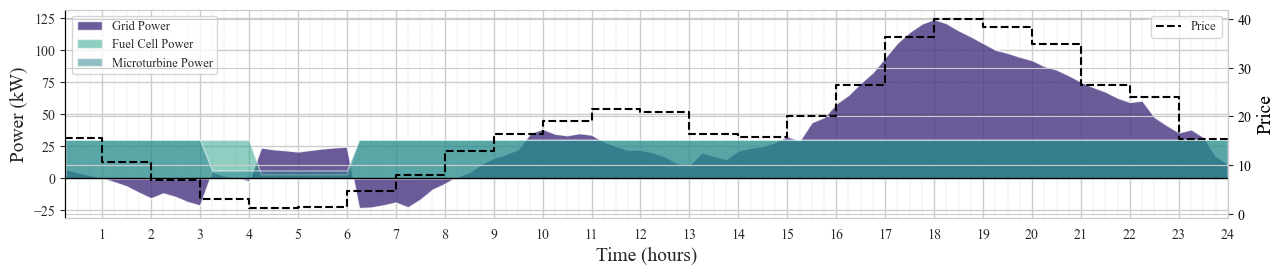

In [35]:
### Plot 2: Grid, FC, and MT Power vs. Price ###
fig, ax1 = plt.subplots(figsize=(15, 2.7))

ax1.fill_between(time_steps, p_grid, color=colors[5], alpha=0.8, label='Grid Power', edgecolor='white')
ax1.fill_between(time_steps, p_FC, color=colors[2], alpha=0.5, label='Fuel Cell Power', edgecolor='white')
ax1.fill_between(time_steps, p_MT, color=colors[3], alpha=0.5, label='Microturbine Power', edgecolor='white')

ax1.set_xlabel("Time (hours)", size=14)
ax1.set_ylabel("Power (kW)", size=14)
ax1.axhline(0, color='black', linewidth=1)

# Second y-axis for price
ax2 = ax1.twinx()
ax2.plot(time_steps, price_data, color='black', linewidth=1.5, linestyle='--', label="Price", drawstyle='steps-pre')
ax2.set_ylabel("Price", size=14, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Grid and legend
ax1.grid(True, which='minor', linestyle='--', linewidth=0.3)
ax1.grid(True, which='major', linestyle='-', linewidth=1)

# Set x-axis ticks
minor_hours = np.arange(0, 24.25, 0.25)
major_hours = np.arange(0, 24.25, 1)
plt.xticks(minor_hours, minor=True)
plt.xticks(major_hours, minor=False)
ax1.set_xlim([0.25,24]) 
ax1.legend(loc='right', fontsize=9)
ax1.spines['left'].set_color('black')
ax2.spines['left'].set_color('black')

ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)

# plt.title("Grid, FC, and MT Power vs. Price")
plt.savefig('power.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

#### storage and SoC

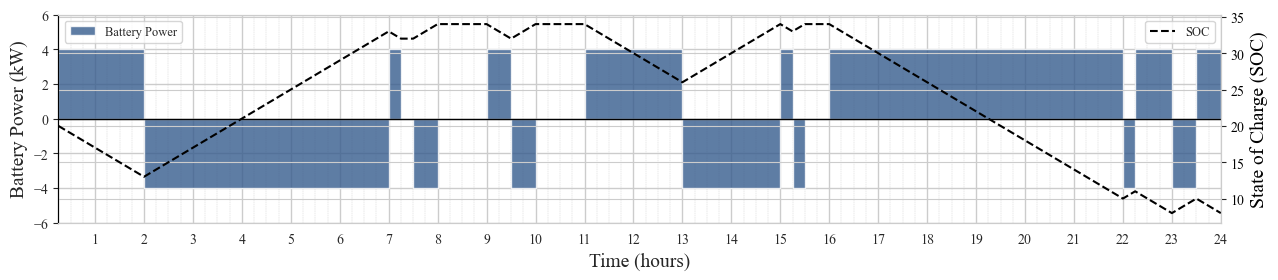

In [34]:
# Time steps (assuming hourly data)
time_steps = np.arange(len(p_storage)) / 4 + 0.25

### Plot 1: Battery Power vs. SOC ###
fig, ax1 = plt.subplots(figsize=(15, 2.7))

ax1.fill_between(time_steps, p_storage, color=colors[4], alpha=0.8, label='Battery Power', edgecolor='white', step='pre')

ax1.set_xlabel("Time (hours)", size=14)
ax1.set_ylabel("Battery Power (kW)", size=14)
ax1.axhline(0, color='black', linewidth=1)

# Second y-axis for price
ax2 = ax1.twinx()
ax2.plot(time_steps, storage_energy, color='black', linewidth=1.5, linestyle='--', label="SOC")
ax2.set_ylabel("State of Charge (SOC)", size=14, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Grid and legend
ax1.grid(True, which='minor', linestyle='--', linewidth=0.3)
ax1.grid(True, which='major', linestyle='-', linewidth=1)

# Set x-axis ticks
minor_hours = np.arange(0, 24.25, 0.25)
major_hours = np.arange(0, 24.25, 1)
plt.xticks(minor_hours, minor=True)
plt.xticks(major_hours, minor=False)
ax1.set_xlim([0.25,24]) 
ax1.set_ylim([-6,6]) 

ax1.legend(loc='right', fontsize=9)
ax1.spines['left'].set_color('black')
ax2.spines['left'].set_color('black')

ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)


# plt.title("Battery Power vs. State of Charge")
plt.savefig('storage.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# Optimization with noise

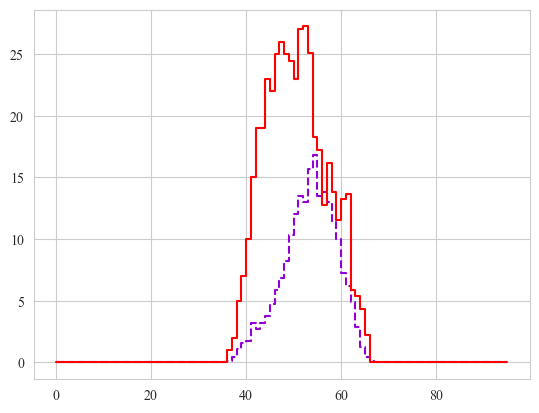

In [23]:
noisy_series.shape
plt.plot(t, pv_data, linestyle='--', color='darkviolet', label='PV Power', drawstyle='steps-post')
plt.plot(t, noisy_series, linestyle='-', color='r', label='noisy PV Power', drawstyle='steps-post')

In [24]:
p_grid_n, p_FC_n, p_MT_n, p_storage_n, storage_energy_n = solve_opt(noisy_series, wt_data)

TypeError: solve_opt() missing 3 required positional arguments: 'load_data_i', 'price_data_i', and 'co2_data_i'

# compare desisions

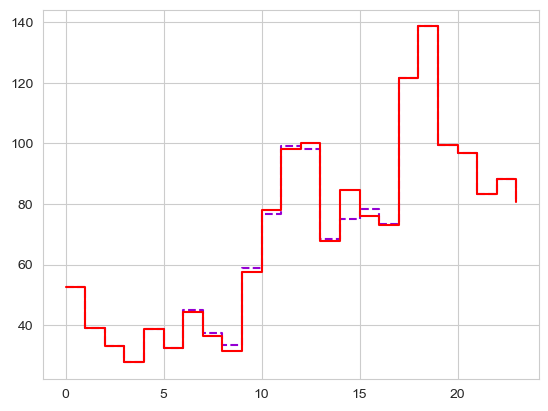

In [9]:
plt.plot(t, p_grid, linestyle='--', color='darkviolet', label='Grid Power', drawstyle='steps-post')
plt.plot(t, p_grid_n, linestyle='-', color='r', label='Noisy Grid Power', drawstyle='steps-post')   

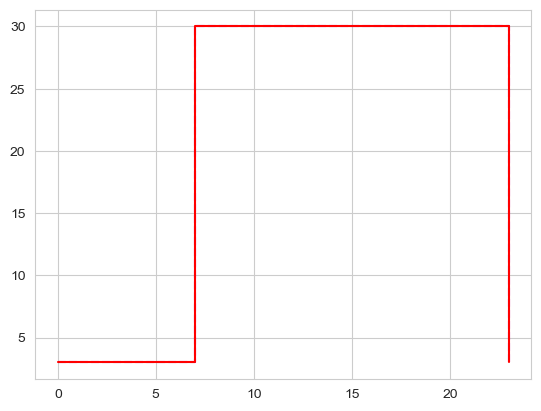

In [10]:
plt.plot(t, p_FC, linestyle='--', color='darkviolet', label='FC Power', drawstyle='steps-post')
plt.plot(t, p_FC_n, linestyle='-', color='r', label='Noisy FC Power', drawstyle='steps-post')

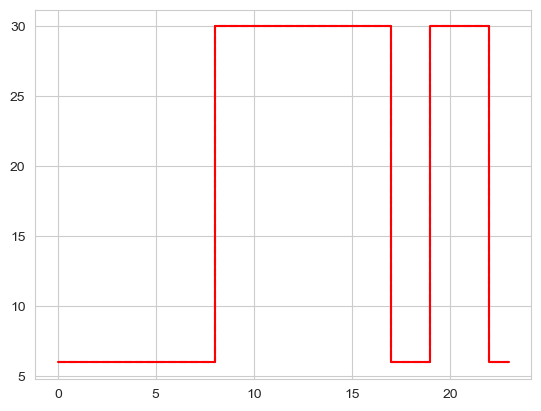

In [11]:
plt.plot(t, p_MT, linestyle='--', color='darkviolet', label='MT Power', drawstyle='steps-post')
plt.plot(t, p_MT_n, linestyle='-', color='r', label='Noisy MT Power', drawstyle='steps-post')

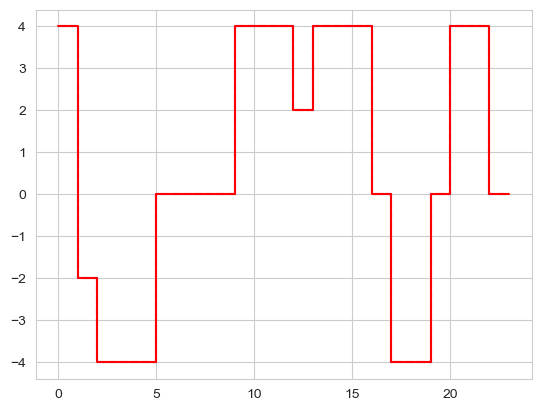

In [12]:
plt.plot(t, p_storage, linestyle='--', color='darkviolet', label='Battery Power', drawstyle='steps-post')
plt.plot(t, p_storage_n, linestyle='-', color='r', label='Noisy Battery Power', drawstyle='steps-post')

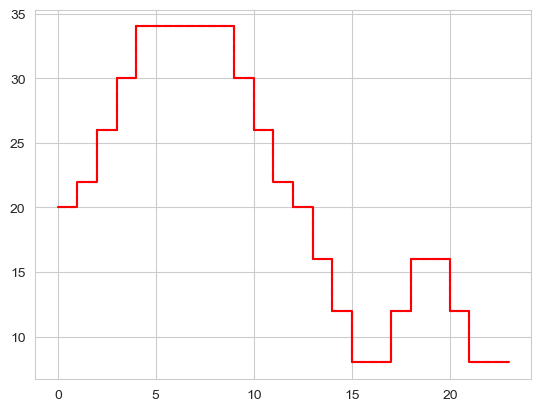

In [13]:
plt.plot(t, storage_energy, linestyle='--', color='darkviolet', label='Battery Energy', drawstyle='steps-post')
plt.plot(t, storage_energy_n, linestyle='-', color='r', label='Noisy Battery Energy', drawstyle='steps-post')

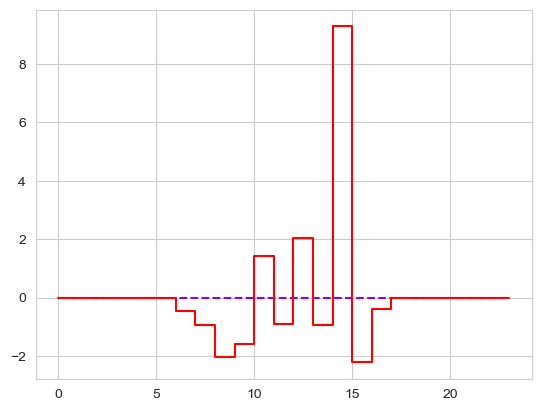

In [14]:
# plot power balance problem

balanced = load_data - (2*pv_data + wt_data + p_grid + p_FC + p_MT + p_storage)
unbalaced = load_data - (2*noisy_series + wt_data + p_grid + p_FC + p_MT + p_storage)
plt.plot(t, balanced, linestyle='--', color='darkviolet', label='Balanced Power', drawstyle='steps-post')
plt.plot(t, unbalaced, linestyle='-', color='r', label='Unbalanced Power', drawstyle='steps-post')